In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib notebook

In [8]:
# read Excel data and combine into one data structure
url = "https://raw.githubusercontent.com/zhihstanford/oitproject/main/KP_Handbag3.xlsx"
data = pd.read_excel(url)

In [9]:
# Define the state to region mapping
state_to_region = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West',
    'CO': 'West', 'CT': 'East', 'DE': 'East', 'FL': 'South', 'GA': 'South',
    'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'KY': 'South', 'LA': 'South', 'ME': 'East', 'MD': 'East',
    'MA': 'East', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South', 'MO': 'Midwest',
    'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'East', 'NJ': 'East',
    'NM': 'West', 'NY': 'East', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest',
    'OK': 'South', 'OR': 'West', 'PA': 'East', 'RI': 'East', 'SC': 'South',
    'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West', 'VT': 'East',
    'VA': 'South', 'WA': 'West', 'WV': 'South', 'WI': 'Midwest', 'WY': 'West',
    'DC': 'East', 'PR': 'South'
}

df = pd.DataFrame(data)

# Function to map state to region
def map_state_to_region(state):
    return state_to_region.get(state, 'International')

# Creating a new 'Region' column by applying the mapping function
df['Region'] = df['Shipping Province'].apply(map_state_to_region)

# Function to add dummy variable columns for each region directly to the DataFrame
def add_region_columns(df):
    # Create dummy variables for the regions based on the 'Region' column
    region_dummies = pd.get_dummies(df['Region'])

    # Concatenate the dummy variables with the original DataFrame
    return pd.concat([df, region_dummies], axis=1)

print(df)

          Name Financial Status  Expired  Paid  Partially_Paid  \
0       #97824             paid        0     1               0   
1       #97825             paid        0     1               0   
2       #97826             paid        0     1               0   
3       #97827             paid        0     1               0   
4       #97828             paid        0     1               0   
...        ...              ...      ...   ...             ...   
35826  #138383             paid        0     1               0   
35827  #138384             paid        0     1               0   
35828  #138385             paid        0     1               0   
35829  #138386             paid        0     1               0   
35830  #138387             paid        0     1               0   

       Partially_Refunded  Pending  Refunded  Voided  Successful_Order  ...  \
0                       0        0         0       0                 1  ...   
1                       0        0         0     

In [10]:
np.random.seed(0)
my_shuffle = np.random.choice(len(df),len(df),replace= False)
data_randomized = df.iloc[my_shuffle,:].reset_index(drop=True)

Successful Order vs. Region, Quantity, Bag Purchased, Last Chance Purchase, Order Total, Month

In [11]:
# Make sure 'Month' column exists
data_randomized['Paid at'] = pd.to_datetime(data_randomized['Paid at'], errors='coerce')  # Handle errors just in case
data_randomized['Month'] = data_randomized['Paid at'].dt.month

In [74]:
region = data_randomized["Region"]
quantity = data_randomized["Lineitem_quantity"]
num_bags = data_randomized["Number_of_Bags"]
last_chance = data_randomized["Last_Chance"]
order_total = data_randomized["Total"]
successful = data_randomized["Successful_Order"]
month = data_randomized["Month"]
payment_method = data_randomized["Payment_Method"]
risk_level = data_randomized["Risk Level"]

region_map = {"West":0, "East":1, "Midwest":2, "South":3, "International":4}
payment_map = {"Shopify":0, "Global":1, "Other":2}
risk_map = {"Low":0, "Medium":1, "High":2}


In [75]:
data_length = len(data_randomized) - np.sum(np.isnan(month))

input_data = np.zeros((data_length, 25), dtype=np.double)
output_data = np.zeros(data_length, dtype=np.double)

i = 0
for j in range(len(data_randomized)):
  # exclude data without month data from the data set
  if not np.isnan(month[j]):

    input_data[i, region_map[region[j]]] = 1
    input_data[i, 5] = quantity[j]
    input_data[i, 6] = num_bags[j]
    input_data[i, 7] = last_chance[j]
    input_data[i, 8] = order_total[j]
    input_data[i, 8+int(month[j])] = 1
    input_data[i, 21+payment_map[payment_method[j]]] = 1
    input_data[i, 24] = risk_map[risk_level[j]]

    output_data[i] = successful[j]

    i = i + 1

In [81]:
# Splitting th data into training and validation sets
fraction_training = 0.6
n_train = int(data_length*fraction_training)
n_validate = data_length - n_train
n_inputs = input_data.shape[1]

In [80]:
training_input = input_data[0:n_train, :]
training_output = output_data[0:n_train]

validation_input = input_data[n_train:, :]
validation_output = output_data[n_train:]

Logistic regression one-layer model

In [83]:
model = Sequential()

# linear regression model
model.add(Dense(1, input_shape=(n_inputs,), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(training_input, training_output, epochs=10, batch_size=10)

_, accuracy = model.evaluate(training_input, training_output)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10


C:\Users\zhixh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7344 - loss: 4.5063
Epoch 2/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8611 - loss: 0.3937
Epoch 3/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8558 - loss: 0.3895
Epoch 4/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8626 - loss: 0.3807
Epoch 5/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8581 - loss: 0.3800
Epoch 6/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8544 - loss: 0.3870
Epoch 7/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8578 - loss: 0.3874
Epoch 8/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8576 - loss: 0.3832
Epoch 9/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8625 - loss: 0.3753
Epoch 10/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8566 - loss: 0.3858
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8603 - loss: 0.3811
Accuracy: 86.25


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
validation accuracy: 0.8631828647177842
predicted sucess rate: 0.9995813856136189
AUC: 0.71


<IPython.core.display.Javascript object>


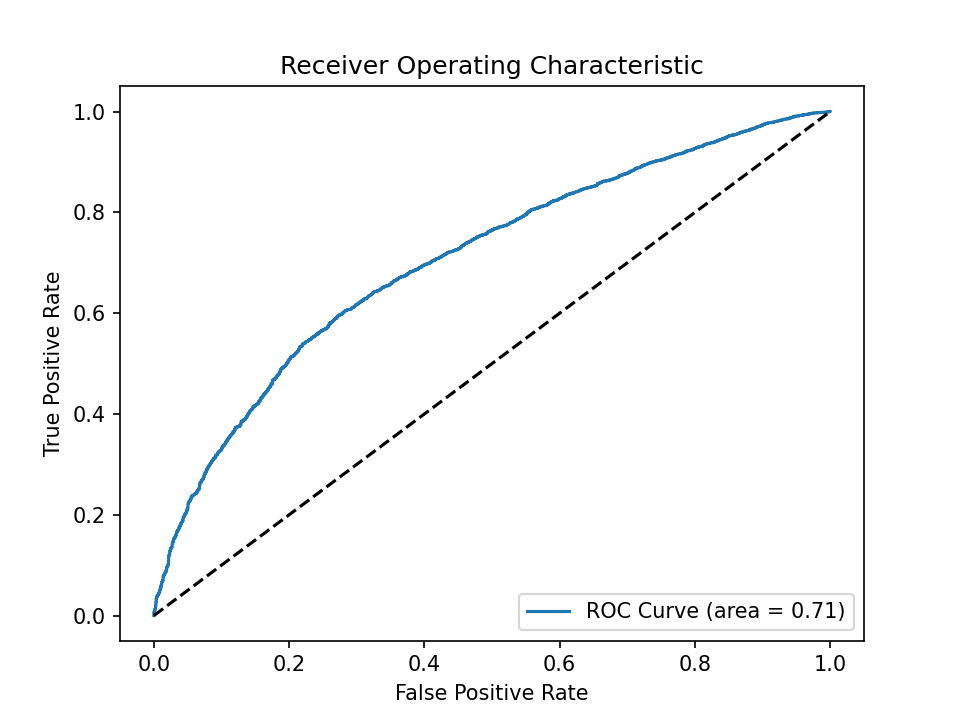

In [84]:
raw_predictions = model.predict(validation_input)
predictions = (raw_predictions > 0.5).astype(int)

validation_accuracy = np.sum((predictions[:,0] == validation_output))/n_validate
print("validation accuracy:", validation_accuracy)
print("predicted sucess rate:", np.sum(predictions[:,0])/n_validate)


# calculate AUC score
auc = roc_auc_score(validation_output, raw_predictions)
print('AUC: %.2f' % auc)

# plot ROC curve
fpr, tpr, thresholds = roc_curve(validation_output, raw_predictions)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Logistic regression one-layer model with Class Weight

In [87]:
# Add more weights for the minority class

from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced', np.unique(training_output), training_output)
class_weights = {0: 2.,
                1: 1.}


model = Sequential()

# logistic regression model
model.add(Dense(1, input_shape=(n_inputs,), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(training_input, training_output, epochs=10, batch_size=10, class_weight=class_weights)

_, accuracy = model.evaluate(training_input, training_output)
print('Accuracy: %.2f' % (accuracy*100))

C:\Users\zhixh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7528 - loss: 1.2150
Epoch 2/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8253 - loss: 0.6282
Epoch 3/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8342 - loss: 0.6005
Epoch 4/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8357 - loss: 0.5948
Epoch 5/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8380 - loss: 0.5934
Epoch 6/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8438 - loss: 0.5871
Epoch 7/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8421 - loss: 0.5895
Epoch 8/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8374 - loss: 0.5909
Epoch 9/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8428 - loss: 0.5907
Epoch 10/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8369 - loss: 0.5956
672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8470 - loss: 0.4115
Accuracy: 84.57


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
validation accuracy: 0.8407172259819996
predicted sucess rate: 0.9353938463685202
AUC: 0.71


<IPython.core.display.Javascript object>


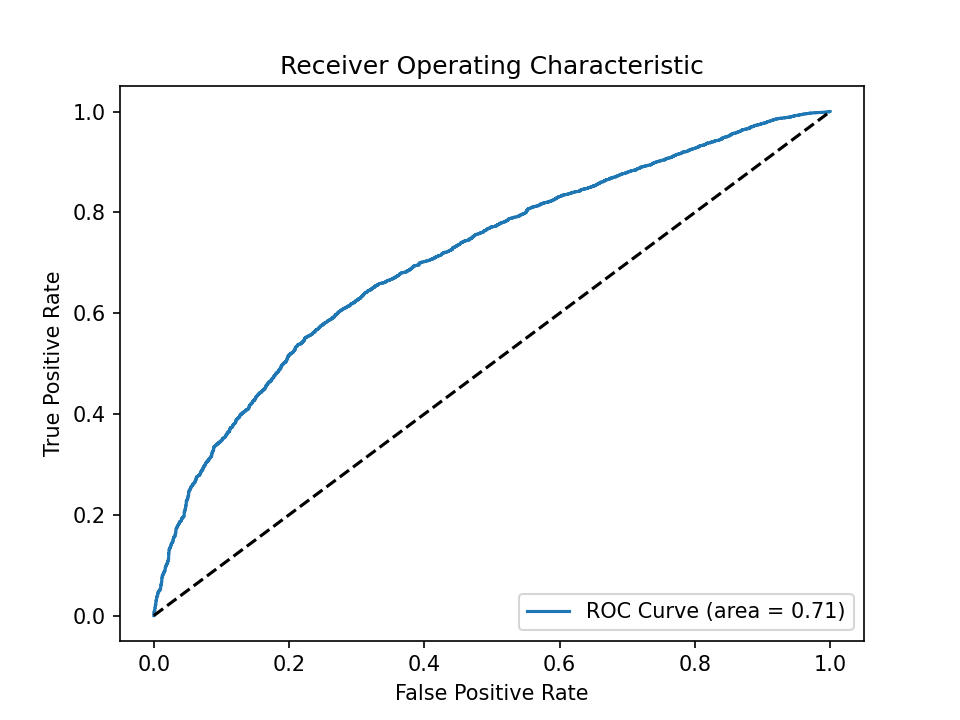

In [88]:
raw_predictions = model.predict(validation_input)
predictions = (raw_predictions > 0.5).astype(int)

validation_accuracy = np.sum((predictions[:,0] == validation_output))/n_validate
print("validation accuracy:", validation_accuracy)
print("predicted sucess rate:", np.sum(predictions[:,0])/n_validate)


# calculate AUC score
auc = roc_auc_score(validation_output, raw_predictions)
print('AUC: %.2f' % auc)

# plot ROC curve
fpr, tpr, thresholds = roc_curve(validation_output, raw_predictions)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

2-layer model with class weights

In [112]:
# Test to see if 2-layer model performs better
from keras.layers import Dense, LeakyReLU

class_weights = {0: 5.,
                1: 1.}

model = Sequential()

# 2-layer model
model.add(LeakyReLU(25, input_shape=(n_inputs,), alpha=0.01))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'auc'])
model.fit(training_input, training_output, epochs=10, batch_size=10, class_weight=class_weights)

_, accuracy, auc = model.evaluate(training_input, training_output)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5715 - auc: 0.5999 - loss: 1.0896
Epoch 2/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6736 - auc: 0.6793 - loss: 1.0105
Epoch 3/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6863 - auc: 0.6721 - loss: 1.0169
Epoch 4/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6981 - auc: 0.6863 - loss: 0.9951
Epoch 5/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6984 - auc: 0.6807 - loss: 1.0080
Epoch 6/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7008 - auc: 0.6876 - loss: 0.9845
Epoch 7/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6927 - auc: 0.6839 - loss: 1.0047
Epoch 8/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6906 - auc: 0.6867 - loss: 1.0040
Epoch 9/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6852 - auc: 0.6783 - loss: 1.0136
Epoch 10/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6889 - auc: 0

448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
validation accuracy: 0.6178050652340752
predicted sucess rate: 0.5582920533035652
AUC: 0.71


<IPython.core.display.Javascript object>


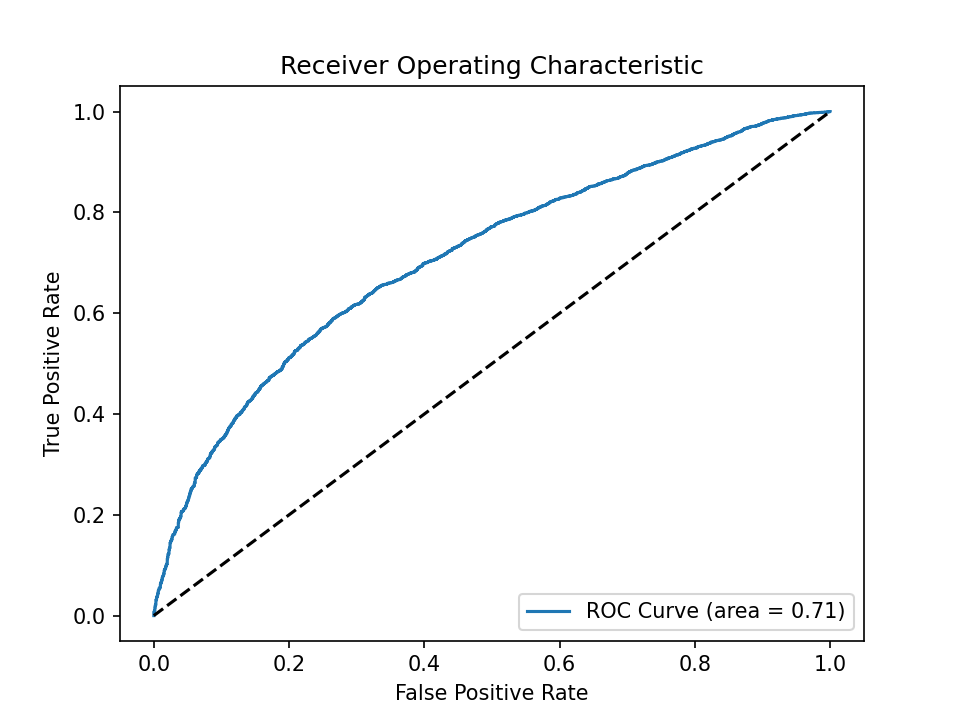

In [113]:
raw_predictions = model.predict(validation_input)
predictions = (raw_predictions > 0.5).astype(int)

validation_accuracy = np.sum((predictions[:,0] == validation_output))/n_validate
print("validation accuracy:", validation_accuracy)
print("predicted sucess rate:", np.sum(predictions[:,0])/n_validate)


# calculate AUC score
auc = roc_auc_score(validation_output, raw_predictions)
print('AUC: %.2f' % auc)

# plot ROC curve
fpr, tpr, thresholds = roc_curve(validation_output, raw_predictions)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()